## xgb 모델을 통해 구현해보기!

In [1]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor


In [2]:
train = pd.read_csv("/Users/unixking/Desktop/데이콘/쇼핑몰지점별매출액예측/dataset/replace2.csv", encoding="utf-8")
test = pd.read_csv("/Users/unixking/Desktop/데이콘/쇼핑몰지점별매출액예측/dataset/replacetest2.csv", encoding="utf-8")

#### 아래처럼 프로모션을 저번 게시글과 함께 프로모션의 결측치 및 
#### Isholiday칼럼을 labelenconder를 통해 바꾸어주었으며 달 일 칼럼을 만들었습니다

In [3]:
train

,Unnamed: 0,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,month,year,week,day
0,0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,0,1643690.90,2,2010,5,5
1,1,2,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,1,1641957.44,2,2010,6,12
2,2,3,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,0,1611968.17,2,2010,7,19
3,3,4,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,0,1409727.59,2,2010,8,26
4,4,5,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,0,1554806.68,3,2010,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,0,734297.87,8,2012,35,31
6251,6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,1,766512.66,9,2012,36,7
6252,6252,6253,45,2012-09-14,67.87,3.948,11407.95,52.54,4.30,3421.72,5268.92,8.684,0,702238.27,9,2012,37,14
6253,6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,0,723086.20,9,2012,38,21


#### test 데이터 또한 똑같이 위처럼 똑같이 해주었습니다.

In [4]:
test

,Unnamed: 0,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Day,Month,Week,year
0,0,1,1,2012-10-05,68.55,3.617,8077.89,31.7500,18.22,3617.430000,3626.14,6.573,0,5,10,40,2012
1,1,2,1,2012-10-12,62.99,3.601,2086.18,31.7500,8.11,602.360000,5926.45,6.573,0,12,10,41,2012
2,2,3,1,2012-10-19,67.97,3.594,950.33,31.7500,4.93,80.250000,2312.85,6.573,0,19,10,42,2012
3,3,4,1,2012-10-26,69.16,3.506,2585.85,31.7500,6.00,1057.160000,1305.01,6.573,0,26,10,43,2012
4,4,5,2,2012-10-05,70.27,3.617,6037.76,56.2550,10.04,3027.370000,3853.40,6.170,0,5,10,40,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,176,44,2012-10-26,46.97,3.755,38.65,2.6100,0.98,2066.530833,457.74,5.217,0,26,10,43,2012
176,176,177,45,2012-10-05,64.89,3.985,5046.74,16.4775,18.82,2253.430000,2340.01,8.667,0,5,10,40,2012
177,177,178,45,2012-10-12,54.47,4.000,1956.28,30.3450,7.89,599.320000,3990.54,8.667,0,12,10,41,2012
178,178,179,45,2012-10-19,56.47,3.969,2004.02,44.2125,3.18,437.730000,1537.49,8.667,0,19,10,42,2012


#### store 함수를 만들어서 지점별로 모델을 통해 분석할 수 있게 만들었으며
#### trian 데이터에서 지점별로 100번째부터가 모두 2012년 데이터이며 
 


#### 결국 2012년 10월을 예측하는 것이므로 2012년 데이터부터 
#### train데이터로 만들었습니다

#### validation 데이터 셋은 지점별로 88번쨰부터 90번째까지 2011년 10월의 데이터이므로 
#### 이 데이터셋이 월별의 영향을 크게 주어 제일 비슷하다고 판단하여 검증용 데이터 셋으로 했습니다

In [9]:
def store(train, test, i):
    train = train[train.Store == i]
    test = test[test.Store == i]
    
    train = train.reset_index()
    train1 = train.iloc[100:]
    vali = train.iloc[88:91]

    return train1, test, vali


#### spl 함수를 통해 지난 게시글에 구현했던 상관관계 분석을 통해 제일 관계 깊은 칼럼들로 다시 재배열합니다

In [10]:
def spl(train, test, vali):
    xtrain = train[['Temperature', 'Fuel_Price','Promotion3', 'month']]
    ytrain = train[["Weekly_Sales"]]
    xvali = vali[['Temperature', 'Fuel_Price','Promotion3', 'month']]
    yvali = vali[["Weekly_Sales"]]
    xtest = test[['Temperature', 'Fuel_Price', 'Promotion3', 'month']]
    
    return xtrain, ytrain, xtest, xvali, yvali


#### MinMaxScaler를 통해 train데이터의 x와 test데이터의 x, validation의 x 들을 모두 표준화 시켰다.

In [11]:
def wjdrb(xtrain, xtest, xvali):
    scaler = MinMaxScaler()
    xtrain = pd.DataFrame(scaler.fit_transform(xtrain))
    xtest = pd.DataFrame(scaler.fit_transform(xtest))
    xvali = pd.DataFrame(scaler.fit_transform(xvali))
    return xtrain, xtest, xvali


#### xgb 모델을 통해 bestparams를 먼저 찾았으며 이를  validaion과 eval_metric로서
#### 예측시킬 수 있게 하였다. early_stoppring을 15로 주어 괴적합을 피하려고 노력하였다.

In [15]:
# 모델 파라미터에 맞게 튜닝
def model(xtrain, ytrain, xtest, xvali, yvali):
    eval_set = [(xvali, yvali)]
    xgb_model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.07, subsample=0.7,
                           colsample_bytree=0.7, max_depth=5, silent = 1, nthread = 4, min_child_weight = 4)
    
    xgb_model.fit(xtrain,ytrain, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=15)
    pred = xgb_model.predict(xtest)
    
    return pred

#### 밑에 함수들은 위에 함수들과 크게 다르지 않고 지점별 추세 비교 때 비선형적인 
#### [36, 38 , 42, 43, 44] 지점을 따로 만들어 xgb 모델이 아닌 randomforest로 모델을 동작시켰습니다.

In [13]:
def store2(train, test, i):
    train = train[train.Store == i]
    test = test[test.Store == i]

    train = train.reset_index()
    train1 = train.iloc[100:]
    
    vali = train[train.month == 10]

    return train1, test, vali


def spl2(train, test, vali):
    xtrain = train[['Temperature', 'Fuel_Price', 'Unemployment', 'IsHoliday','month']]
    ytrain = train[["Weekly_Sales"]]
    xtest = test[['Temperature', 'Fuel_Price', 'Unemployment' ,'IsHoliday', 'month']]
    xvali = vali[['Temperature', 'Fuel_Price', 'Unemployment', 'IsHoliday','month']]
    yvali = vali[["Weekly_Sales"]]

    return xtrain, ytrain, xtest, xvali, yvali

def wjdrb2(xtrain, xtest, xvali):
    scaler = MinMaxScaler()
    xtrain = pd.DataFrame(scaler.fit_transform(xtrain))
    xtest = pd.DataFrame(scaler.fit_transform(xtest))
    xvali = pd.DataFrame(scaler.fit_transform(xvali))
    
    return xtrain, xtest, xvali


In [12]:
def model2(xtrain, ytrain, xtest):
    model = RandomForestRegressor()
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    
    return pred


In [23]:
if __name__ == '__main__':
    
    result = []
    exc = [36, 38 , 42, 43, 44]    ## 비선형적인 지점들의 대한 리스트
    for i in range(1, 46):
        
        if i in exc:
            print(i)
            train1, test1, vali = store2(train, test, i)
            xtrain, ytrain, xtest, xvali, yvali = spl2(train1, test1, vali)
            xtrain, xtest, xvali = wjdrb2(xtrain, xtest, xvali)
            predict = model2(xtrain, ytrain, xtest)

        else:
            print(i)
            train1, test1, vali = store(train, test, i)
            xtrain, ytrain, xtest, xvali, yvali = spl(train1, test1, vali)
            xtrain, xtest, xvali = wjdrb(xtrain, xtest, xvali)
            predict = model(xtrain, ytrain, xtest, xvali, yvali)

        for i in predict:
            result.append(i)


1
[02:09:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1375133.00000
[1]	validation_0-rmse:1273277.87500
[2]	validation_0-rmse:1180292.50000
[3]	validation_0-rmse:1093490.62500
[4]	validation_0-rmse:1012775.06250
[5]	validation_0-rmse:936010.12500
[6]	validation_0-rmse:865252.06250
[7]	validation_0-rmse:800466.12500
[8]	validation_0-rmse:738371.37500
[9]	validation_0-rmse:680734.50000
[10]	validation_0-rmse:627694.18750
[11]	validation_0-rmse:577892.93750
[12]	validation_0-rmse:531178.81250
[13]	validation_0-rmse:486626.65625
[14]	validation_0-rmse:447660.25000
[15]	validation_0-rmse:41080

In [17]:
col = ['col1']
df_result = pd.DataFrame(result, columns = col)

In [19]:
pd.options.display.float_format = '{:.2f}'.format
df_result

,col1
0,1491555.38
1,1494095.62
2,1491555.38
3,1446012.12
4,1789016.25
...,...
175,316711.28
176,735712.44
177,722179.31
178,729115.88


### 밑에 시각화를 통해 위 예측된 값으로 빨간색의 예측값과 기존 추세를 비교할 수 있습니다.

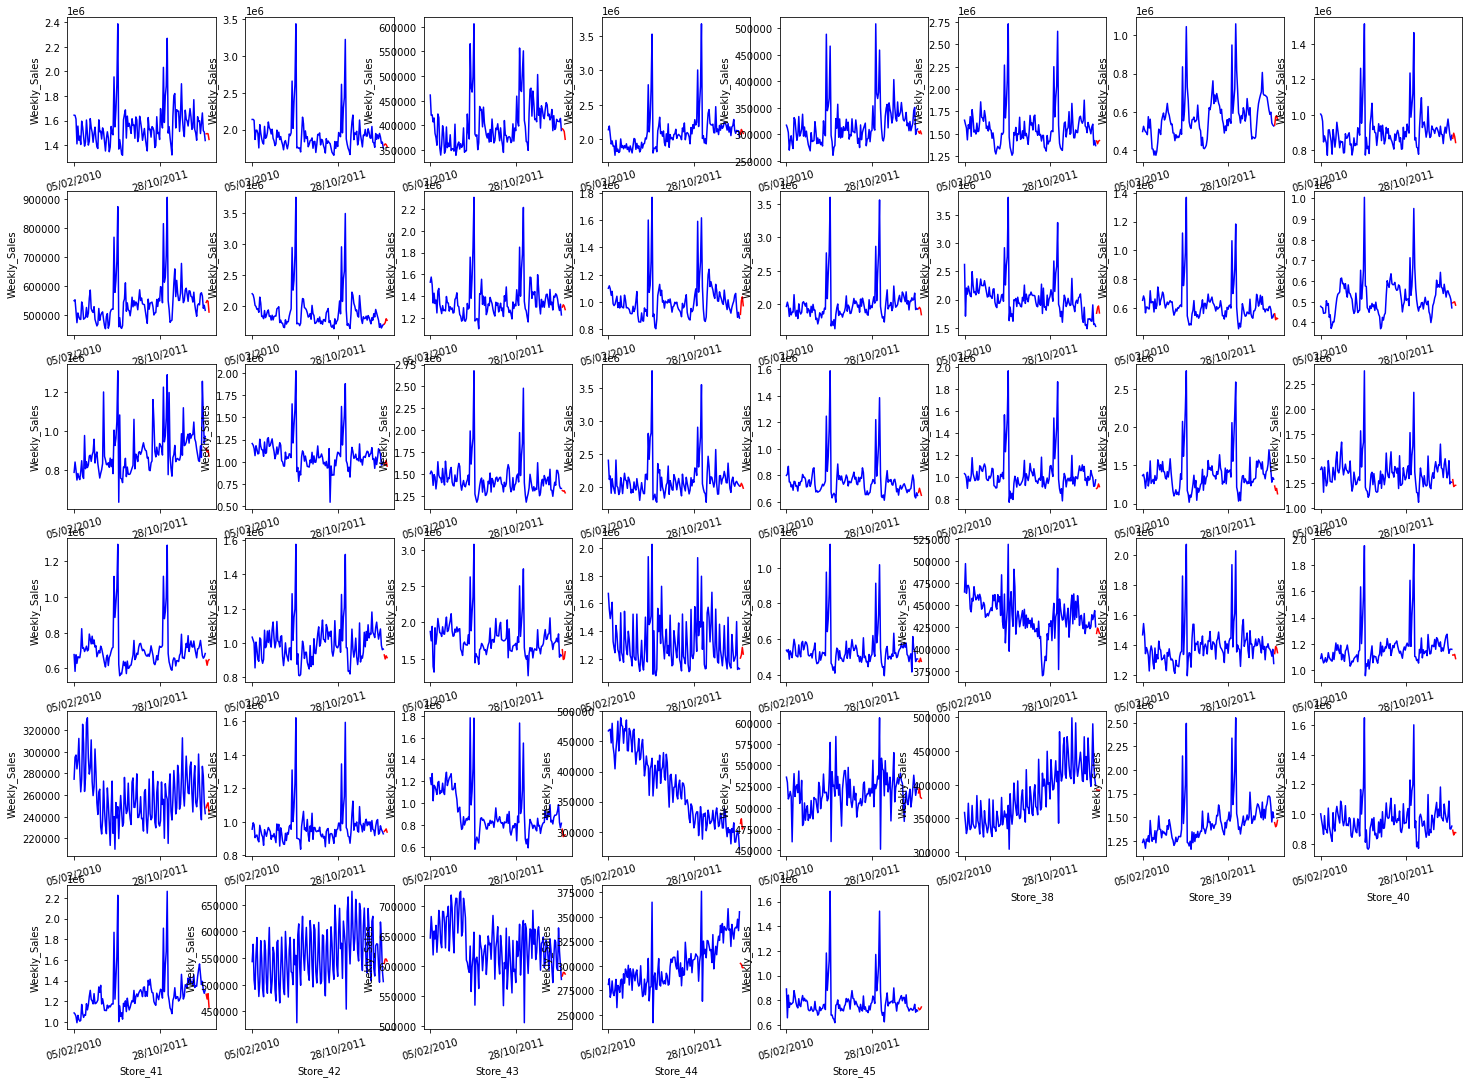

In [22]:
import pandas as pd
from matplotlib import dates

#Visualizing
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette

train = pd.read_csv("/Users/unixking/Desktop/데이콘/쇼핑몰지점별매출액예측/dataset/replace2.csv", encoding="utf-8")
data = pd.read_csv("/Users/unixking/Desktop/데이콘/쇼핑몰지점별매출액예측/dataset/replacetest2.csv", encoding="utf-8")

fig = plt.figure(figsize=(25,25)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
exc = [36, 38 , 42, 43, 44]
#for i in exc:
for i in range(1,46):
    train2 = train[train.Store == i]
    data2 = data[data.Store == i]

    train2  = train2[["Date", "Weekly_Sales"]]
    test2 = data2[["Date", "Weekly_Sales"]]

    train2= train2.reset_index()
    #train2 = train2.iloc[100:]
    test2 = test2.reset_index()

    ax = fig.add_subplot(8,8,i) ## 그림 뼈대(프레임) 생성

    plt.xlabel("Store_{}".format(i)) 
    plt.ylabel('Weekly_Sales')
    plt.xticks(rotation=15)
    ax.xaxis.set_major_locator(dates.MonthLocator(interval = 3))
    

    ax.plot(train2['Date'] ,train2["Weekly_Sales"],marker='',label='train', color="blue")
    ax.plot(test2['Date'], test2["Weekly_Sales"], label=test2, color="red") 
plt.show()
